**Notebook 3 of 3**

![alt text](https://miro.medium.com/max/700/0*VbMjGBHMC6GnDKUp.png)


Detectron2 is Facebook AI Research's next generation software system that implements state-of-the-art object detection algorithms. It is a ground-up rewrite of the previous version, Detectron, and it originates from maskrcnn-benchmark. The main feature of the Detectron2 is how they enhanced the training time.


The real power of Detectron2 lies in the HUGE amount of pre-trained models available at the Model Zoo. In addition, the Detectron2 is extendible so a lot of custom configuration can be added.


# Installation

In [ ]:
!pip install -q -U git+https://github.com/albumentations-team/albumentations
!pip install -q pyyaml==5.1 pycocotools>=2.0.1
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import copy
import cv2
import torch
import torchvision
import pycocotools
import detectron2
import random
import itertools

from tqdm.notebook import tqdm
from glob import glob
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.structures import BoxMode
from detectron2.data import datasets, DatasetCatalog, MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
from detectron2.evaluation import COCOEvaluator, verify_results
from detectron2.modeling import GeneralizedRCNNWithTTA
from detectron2.data.transforms import TransformGen
from detectron2.utils.logger import setup_logger
setup_logger()

from fvcore.transforms.transform import TransformList, Transform, NoOpTransform
from contextlib import contextmanager

SEED = 44

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Configurations



In [ ]:
# MODEL_PATH = 'COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml'
MODEL_PATH = 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'

TRAIN_IMAGE_PATH  = '/content/drive/My Drive/CV/Global Wheat Detection/train'
TEST_IMAGE_PATH  = '/content/drive/My Drive/CV/Global Wheat Detection/test'
DATA_PATH = '/content/drive/My Drive/CV/Global Wheat Detection/train.csv'
OUTPUT_PATH ='/content/drive/My Drive/Colab Notebooks/checkpoints/Detectron2'
images_ids = [p.split('/')[-1].split('.')[0] for p in glob(f'{TRAIN_IMAGE_PATH}/*.jpg')]


# Import GWD Dataset 

In [6]:
def read_csv(path) -> pd.DataFrame:

    df = pd.read_csv(path)
    bboxes = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))

    for i, column in enumerate(['x_min', 'y_min', 'width', 'height']):
        df[column] = bboxes[:,i]
    
    df["x_max"] = df.apply(lambda col: col.x_min + col.width, axis=1)
    df["y_max"] = df.apply(lambda col: col.y_min + col.height, axis=1)
    df["area"] = df.apply(lambda col: col.width * col.height, axis=1)
    df["class"] = 1 # 1 for wheat, 0 for background

    df.drop(columns=['source'], inplace=True)
    df.drop(columns=['bbox'], inplace=True)

    return df

train_df = read_csv(DATA_PATH)
train_df.head()

image_id  width  height  x_min  y_min  x_max  y_max     area  class
0  b6ab77fd7   56.0    36.0  834.0  222.0  890.0  258.0   2016.0      1
1  b6ab77fd7  130.0    58.0  226.0  548.0  356.0  606.0   7540.0      1
2  b6ab77fd7   74.0   160.0  377.0  504.0  451.0  664.0  11840.0      1
3  b6ab77fd7  109.0   107.0  834.0   95.0  943.0  202.0  11663.0      1
4  b6ab77fd7  124.0   117.0   26.0  144.0  150.0  261.0  14508.0      1

# Custom Augmentation

Detectron2 has limited augemntations(Transformation), but they provided the Transform module to make custom augmentations 

In [7]:
class CutOut(Transform):
    
    def __init__(self, box_size=25, prob_cutout=0.5):
        super().__init__()
        
        self.box_size = box_size
        self.prob_cutout = prob_cutout       
    def apply_image(self, img):

        if random.random() > self.prob_cutout:
            
            h, w = img.shape[:2]
            num_rand = np.random.randint(10, 20)
            for num_cut in range(num_rand):
                x_rand, y_rand = random.randint(0, w-self.box_size), random.randint(0, h-self.box_size)
                img[x_rand:x_rand+self.box_size, y_rand:y_rand+self.box_size, :] = 0
        
        return np.asarray(img)
    
    def apply_coords(self, coords):
        return coords.astype(np.float32)


# Data Pre-processing
Before jumping into the Training phase preprocessing should be done.
first, we need to create a function that will convert our dataset into a format that is used by Detectron2
The format can be reviewed at the [tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5) that is provided by FAIR themselves, or can be found at their [documentations](https://detectron2.readthedocs.io/).

I converted every annotation row to a single record with a list of annotations. You might also notice the polygon that is of the exact same shape as the bounding box. This is required for the image segmentation models in Detectron2.

In [ ]:
IMAGE_SIZE = 1024
def custom_dataset(df, dir_image):
    
    dataset_dicts = []
    
    for img_id, img_name in enumerate(images_ids):
        
        record = {}
        image_df = df[df['image_id'] == img_name]
        img_path = f'{dir_image}/{img_name}.jpg'
        
        record['file_name'] = img_path
        record['image_id'] = img_id
        record['height'] = 1024
        record['width'] = 1024
                
        objs = []
        for _, row in image_df.iterrows():
            
            x_min = int(row.x_min)
            y_min = int(row.y_min)
            x_max = int(row.x_max)
            y_max = int(row.y_max)
            
            poly = [(x_min, y_min), (x_max, y_min),
                    (x_max, y_max), (x_min, y_max) ]
            
            poly = list(itertools.chain.from_iterable(poly))
            
            obj = {
               "bbox": [x_min, y_min, x_max, y_max],
               "bbox_mode": BoxMode.XYXY_ABS,
               "segmentation": [poly],
               "category_id": 0,
               "iscrowd" : 0
                
                  }
            
            objs.append(obj)
            
        record['annotations'] = objs
        dataset_dicts.append(record)
        
    return dataset_dicts

# Data Mapper

Now, we should implement a mapper function. This function will help us customize the data loader. We this we can add more augmentations and add other configurations for the images. 

In [16]:

def custom_mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
                    T.Resize((512,512)),
                    T.RandomBrightness(0.6, 1.6),
                    T.RandomContrast(0.6, 3),
                    T.RandomSaturation(0.1, 2),
                    T.RandomRotation(angle=[90, 90]),
                    T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
                    T.RandomFlip(prob=0.4, horizontal=True, vertical=False), 
                    CutOut()
                    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


class WheatTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
        


# Data Registration
After the customaztions, I had to regitser the dataset so that the model well recognize it as a legitimate dataset.

In [ ]:

def register_dataset(df, dataset_label='wheat_train', image_dir = TRAIN_IMAGE_PATH):
    
    # Register dataset - if dataset is already registered, give it a new name    
    try:
        DatasetCatalog.register(dataset_label, lambda d=df: custom_dataset(df, image_dir))
        MetadataCatalog.get(dataset_label).set(thing_classes = ['wheat'])
    except:
        # Add random int to dataset name to not run into 'Already registered' error
        n = random.randint(1, 1000)
        dataset_label = dataset_label + str(n)
        DatasetCatalog.register(dataset_label, lambda d=df: custom_dataset(df, image_dir))
        MetadataCatalog.get(dataset_label).set(thing_classes = ['wheat'])

    return MetadataCatalog.get(dataset_label), dataset_label

metadata, train_dataset = register_dataset(train_df)

## Done! Now we can train the model.
---

# **Detectron2 Configurations**

Detectron2 has 2 models that can be trained 
1. FasterRCNN
2. RetinaNet

I chose the retina net because Faster RCNN models were used.

# **RetinaNet** 

RetinaNet is a single, unified network composed of a backbone network and two task-specific subnetworks. The backbone is responsible for computing a conv feature map over an entire input image and is an off-the-self convolution network. The first subnet performs classification on the backbones output; the second subnet performs convolution bounding box regression.
The retinanet model uses Focal loss as the classification loss, and SmoothL1 as the box regression loss.

# **Focal Loss**
Focal loss is the reshaping of cross entropy loss such that it down-weights the loss assigned to well-classified examples. The novel focal loss focuses training on a sparse set of hard examples and prevents the vast number of easy negatives from overwhelming the detector during training.


After a hours and hours of reviewing the configuration class of the Detectron2's RetinaNet I've finally found how to tune the loss functions parameters, and how to control the learning rates.

more information about the configurations can be found [HERE](https://detectron2.readthedocs.io/modules/config.html#config-references)

In [43]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_PATH)  # f'{OUTPUT_PATH}/model_final.pth' 

# RETINA
cfg.MODEL.RETINANET.NUM_CLASSES = 1 # Configuring the number of outputs

# RetinaNet Loss parameters
cfg.MODEL.RETINANET.FOCAL_LOSS_GAMMA = 4.0
cfg.MODEL.RETINANET.FOCAL_LOSS_ALPHA = 0.25
cfg.MODEL.RETINANET.SMOOTH_L1_LOSS_BETA = 0.5

cfg.DATASETS.TRAIN = (train_dataset,)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 4
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False # True if u want to exclude "empty" images

cfg.SOLVER.IMS_PER_BATCH = 2 

# cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR' 
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.GAMMA = 0.05
cfg.SOLVER.MAX_ITER = 15000 # 20000 - was used in the competition 
cfg.SOLVER.WEIGHT_DECAY = 1e-3
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.STEPS = (1000,2000,10000,)
cfg.OUTPUT_DIR = OUTPUT_PATH
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = WheatTrainer(cfg)

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[08/07 15:00:22 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

# Data visualization

In [ ]:
train_data_loader = trainer.build_train_loader(cfg)
data_iter = iter(train_data_loader)
batch = next(data_iter)

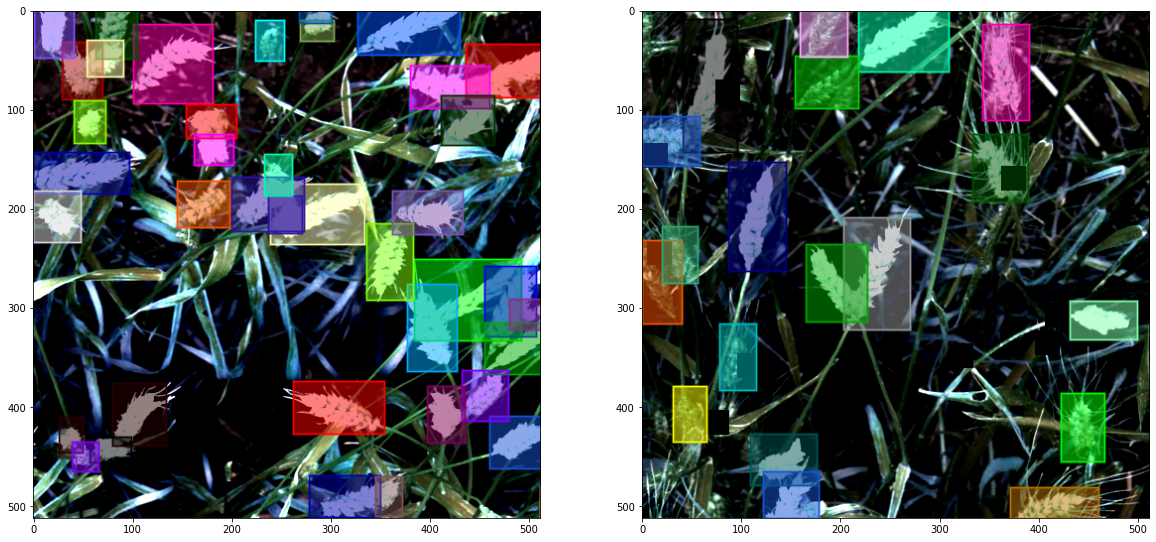

In [19]:
rows, cols = 1, 2
plt.figure(figsize=(20,20))

for i, per_image in enumerate(batch[:2]):
    
    plt.subplot(rows, cols, i+1)
    
    # Pytorch tensor is in (C, H, W) format
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

    visualizer = Visualizer(img, metadata=metadata, scale=1.0)

    target_fields = per_image["instances"].get_fields()
    labels = None
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    plt.imshow(vis.get_image()[:, :, ::-1])

In [44]:
trainer.resume_or_load(resume=True)
trainer.train()

[08/07 15:01:12 d2.engine.train_loop]: Starting training from iteration 5000
[08/07 15:01:17 d2.utils.events]:  eta: 0:40:01  iter: 5019  total_loss: 0.215  loss_cls: 0.118  loss_box_reg: 0.101  time: 0.2322  data_time: 0.0450  lr: 0.000001  max_mem: 10044M
[08/07 15:01:22 d2.utils.events]:  eta: 0:38:07  iter: 5039  total_loss: 0.135  loss_cls: 0.072  loss_box_reg: 0.066  time: 0.2270  data_time: 0.0133  lr: 0.000001  max_mem: 10044M
[08/07 15:01:27 d2.utils.events]:  eta: 0:38:03  iter: 5059  total_loss: 0.129  loss_cls: 0.065  loss_box_reg: 0.065  time: 0.2278  data_time: 0.0136  lr: 0.000001  max_mem: 10044M
[08/07 15:01:31 d2.utils.events]:  eta: 0:38:01  iter: 5079  total_loss: 0.143  loss_cls: 0.074  loss_box_reg: 0.068  time: 0.2271  data_time: 0.0117  lr: 0.000001  max_mem: 10044M
[08/07 15:01:36 d2.utils.events]:  eta: 0:37:59  iter: 5099  total_loss: 0.150  loss_cls: 0.077  loss_box_reg: 0.072  time: 0.2279  data_time: 0.0115  lr: 0.000001  max_mem: 10044M
[08/07 15:01:40 d2

In [ ]:
def cfg_test():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
    cfg.MODEL.WEIGHTS = f'{OUTPUT_PATH}/model_final.pth'
    cfg.DATASETS.TEST = ('wheat_test',)
    cfg.MODEL.RETINANET.NUM_CLASSES = 1
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.4
    return cfg

cfg = cfg_test()
predict = DefaultPredictor(cfg)

# Results - Visualization

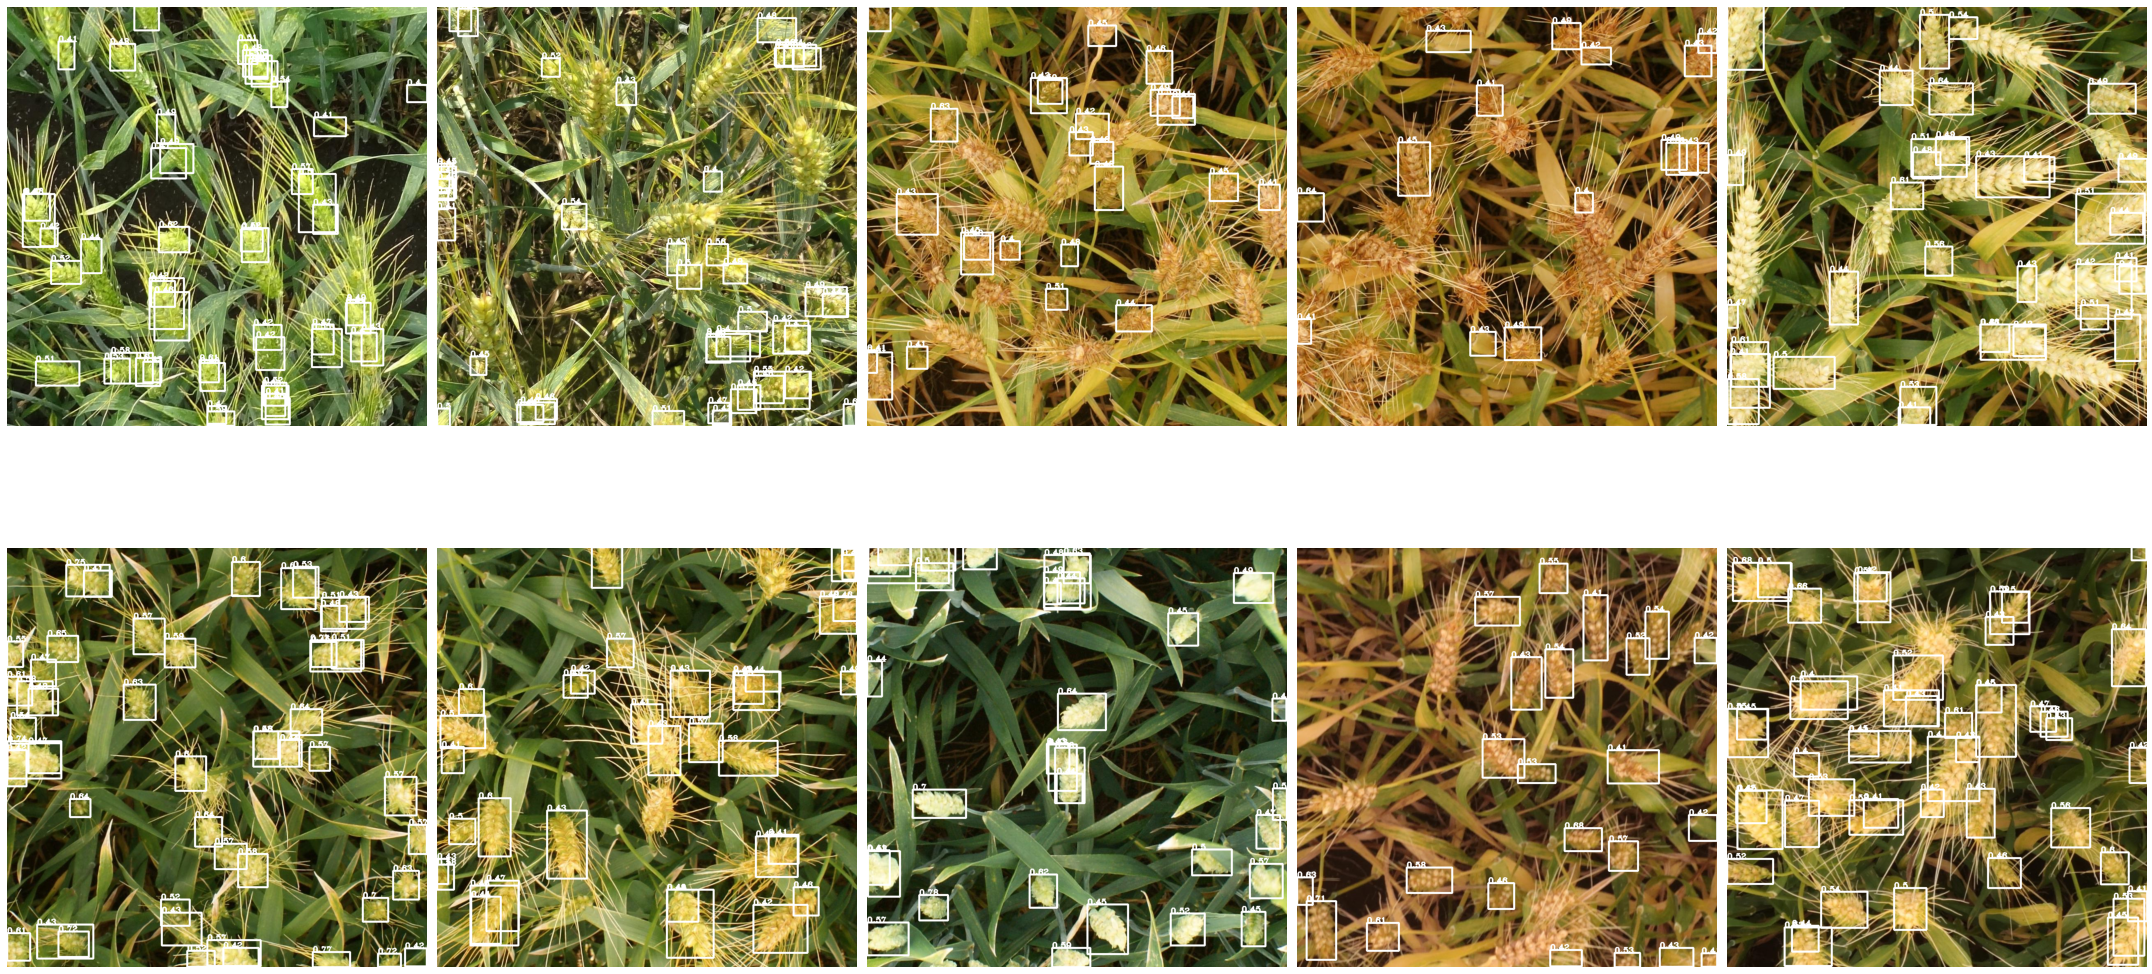

In [64]:
df_sub = pd.read_csv('/content/drive/My Drive/CV/Global Wheat Detection/sample_submission.csv')
TEST_DIR = '/content/drive/My Drive/CV/Global Wheat Detection/test'

fig, ax = plt.subplots(2, 5, figsize=(30, 17))
subplot_indexes = [(x,y) for x in range(2) for y in range(5)]
for index, image_id in enumerate(df_sub['image_id']):
    im = cv2.imread('{}/{}.jpg'.format(TEST_DIR, image_id))
    boxes = []
    scores = []
    labels = []
    outputs = predict(im)
    out = outputs["instances"].to("cpu")
    scores = out.get_fields()['scores'].numpy()
    boxes = out.get_fields()['pred_boxes'].tensor.numpy().astype(int)
    labels= out.get_fields()['scores'].numpy()
    boxes = boxes.astype(int)
    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB).astype(np.float32)
    im /= 255.0
    
    for b,s in zip(boxes,scores):
        cv2.rectangle(im, (b[0],b[1]), (b[0]+b[2],b[1]+b[3]), (1,1,1), 3)
        cv2.putText(im, '{:.2}'.format(s), (b[0],b[1]), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (1,1,1), 2)
    ax[subplot_indexes[index]].set_axis_off()
    ax[subplot_indexes[index]].imshow(im)

fig.tight_layout()
fig.show()

# Conclusions
I got a low score on the leader boards with this model, I was very **disappointed** with the models low performance. I searched for performance boosting for the detectron2 but I haven't found any sources(maybe because its still new), I tried tuning the parameters, tried several models, but in the end the model's score wasn't getting any higher. I believe that I could boost its performance by adding more custom augmentations or change the LR scheduler, but because of lack of time I haven't done any extra work. On the future I will get the most of this model (maybe on different competition :)).